In [17]:
import os
import os.path as osp

import time
import os, mmap
import torch
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.utils import add_self_loops
from sklearn.manifold import TSNE
import numpy as np
from torch_geometric.datasets import Planetoid
import nvsmi
import threading
import psutil

# Using MMAP LoadData

In [18]:
from ctypes import *
result = cdll.LoadLibrary("./mmaploader.so")


# str_test="need_bytes"  
# val=str_test.encode()  
# func.strTest.restype = c_char_p
# file = c_char("/mnt/mem/cora.cites")
start_time = time.perf_counter()

file = bytes("/mnt/mem/cora.cites",encoding='utf-8')
result.readMMap.restype = c_char_p
cites = result.readMMap(file, 0, 10000);

file = bytes("/mnt/mem/cora.content",encoding='utf-8')
result.readMMap.restype = c_char_p
content = result.readMMap(file, 0, 200000000);

end_time = time.perf_counter()
# result.closemmap(bytes(m,encoding='utf-8'))

In [19]:
print('Loading time: ' + str(end_time - start_time))

Loading time: 0.016042746000039187


In [20]:
# Index dictionary, converting the original paper id to encode from 0
index_dict = dict()
# Tag dictionary, converting string tags to values
label_to_index = dict()

features = []
labels = []
edge_index = []
# start timer
start_time = time.perf_counter()

nodes = content.decode().split("\n")[:-1]
for node in nodes:
    node_info = node.split()
    print(node_info)
    index_dict[int(node_info[0])] = len(index_dict)
    features.append([int(i) for i in node_info[1:-1]])

    label_str = node_info[-1]
    if (label_str not in label_to_index.keys()):
        label_to_index[label_str] = len(label_to_index)
    labels.append(label_to_index[label_str])

edges = cites.decode().split("\n")[:-1]
for edge in edges:
    start, end = edge.split()
    # The edges are treated as undirected for training purposes, but the original edges are directed, 
    #so they need to be added forward and backward twice
    edge_index.append([index_dict[int(start)], index_dict[int(end)]])
    edge_index.append([index_dict[int(end)], index_dict[int(start)]])

# end timer
end_time = time.perf_counter()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [21]:
print('Data proccessing time: ' + str(end_time - start_time))

Data proccessing time: 1.1712020609998035


# Using DirectIO LoadData

In [22]:
import directio
path = "/mnt/mem/"
cites = path + "cora.cites"
content = path + "cora.content"

# Index dictionary, converting the original paper id to encode from 0
index_dict = dict()
# Tag dictionary, converting string tags to values
label_to_index = dict()

features = []
labels = []
edge_index = []
# start timer
start_time = time.perf_counter()

# fd = open(cites, "r")
fd_o = os.open(content, os.O_DIRECT | os.O_RDONLY)
# print(fd)
# m = mmap.mmap(fd, 0)
content = directio.read(fd_o,10521600)

fd_o1 = os.open(cites, os.O_DIRECT | os.O_RDONLY)
cites = directio.read(fd_o1,70144)

end_time = time.perf_counter()
print('Loading time: ' + str(end_time - start_time))



Loading time: 0.004561378999824228


In [23]:
start_time = time.perf_counter()
nodes = content.decode().split("\n")[:-1]
for node in nodes:
    node_info = node.split()
    print(node_info)
    index_dict[int(node_info[0])] = len(index_dict)
    features.append([int(i) for i in node_info[1:-1]])

    label_str = node_info[-1]
    if (label_str not in label_to_index.keys()):
        label_to_index[label_str] = len(label_to_index)
    labels.append(label_to_index[label_str])

edges = cites.decode().split("\n")[:-1]
for edge in edges:
    start, end = edge.split()
    # The edges are treated as undirected for training purposes, but the original edges are directed, 
    #so they need to be added forward and backward twice
    edge_index.append([index_dict[int(start)], index_dict[int(end)]])
    edge_index.append([index_dict[int(end)], index_dict[int(start)]])
end_time = time.perf_counter()


['31336', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [24]:
print('Data proccessing time: ' + str(end_time - start_time))

Data proccessing time: 1.3976431019996198


# Create Dataset

In [25]:
# To Tensor
labels = torch.LongTensor(labels)
features = torch.FloatTensor(features)
# norm
# features = torch.nn.functional.normalize(features, p=1, dim=1)
edge_index = torch.LongTensor(edge_index)

In [31]:
mask = torch.randperm(len(index_dict))
train_mask = mask[0:2708]
val_mask = mask[0:2708]
test_mask = mask[0:2708]

dataset = Data(x=features, edge_index=edge_index.t().contiguous(), y=labels, num_classes =7,test_mask=test_mask, train_mask=train_mask, val_mask=val_mask)


In [32]:
print(dataset)

Data(x=[2708, 1433], edge_index=[2, 10858], y=[2708], num_classes=7, test_mask=[2708], train_mask=[2708], val_mask=[2708])


# Test system evaluation metric

In [40]:
import nvsmi
import threading
import psutil
import os
import os.path as osp


disk_io_counter = psutil.disk_io_counters()
disk_total = disk_io_counter[2] + disk_io_counter[3]  # read_bytes + write_bytes
p = psutil.Process(os.getpid())
group_mem_rss = []
group_disk_usage = []
group_iowait = []
t_status = True

def get_gpu_info():
    while True:
        if not t_status:
            break
        group_mem_rss.append(psutil.Process(os.getpid()).memory_info().rss)
        io_counters = p.io_counters()
        disk_usage = io_counters[2] + io_counters[3]
        group_disk_usage.append(disk_usage)  # read_bytes + write_bytes
        try:
            a = psutil.cpu_times_percent().iowait
        except:
            a = 0
        group_iowait.append(a)
#         print(f"{disk_usage / 1024 / 1024} Mb/s")
#         time.sleep(0.09)

# Sampling

In [41]:
from torch_geometric.datasets import Planetoid
from torch_geometric.datasets import Reddit
import torch
from torch_geometric.loader import NeighborSampler
# from NS import NeighborSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from SAGEConv import SAGEConv
from tqdm import tqdm
import torch.optim as optim
import numpy as np
import time
from torch_geometric.data import ClusterData, ClusterLoader, NeighborSampler

# from torch.utils.data import DataLoader

# 图聚类

start_time = time.time()
t = threading.Thread(target=get_gpu_info)
t.start()
cluster_data = ClusterData(dataset, num_parts=128, recursive=False)
train_loader = ClusterLoader(cluster_data, batch_size=16, shuffle=True,
                             num_workers=2)
end_time = time.time()

init_sample_time = end_time - start_time
# 不聚类
subgraph_loader = NeighborSampler(dataset.edge_index, sizes=[-1], batch_size=1024,
                                  shuffle=False, num_workers=2)

# # Reddit
# train_loader = NeighborSampler(dataset[0].edge_index, node_idx=dataset[0].train_mask,
#                                sizes=[25, 10], batch_size=1024, shuffle=True,
#                                num_workers=8,pin_memory=True)
t_status = False
t.join()

end_time = time.time()
init_sample_time = end_time - start_time
print('NeighborSampler time:{}'.format(end_time - start_time))
print(f'内存使用：{np.mean(group_mem_rss) / 1024 / 1024 / 1024:.4f} GB')
print(f'磁盘IO使用：{np.mean(group_disk_usage) / 1024 / 1024 / 1024:.4f} GB/s')
print(f'磁盘IO使用率：{np.mean(group_disk_usage) * 100 / disk_total:.4f}%')
print(f'cpu iowait：{np.mean(group_iowait)}')

NeighborSampler time:0.17333459854125977
内存使用：0.3146 GB
磁盘IO使用：0.1337 GB/s
磁盘IO使用率：2.4900%
cpu iowait：0.0


Computing METIS partitioning...
Done!


In [39]:
# import torch
import torch.nn.functional as F
from torch.nn import ModuleList
from tqdm import tqdm
from torch_geometric.datasets import Reddit
from torch_geometric.data import ClusterData, ClusterLoader, NeighborSampler
from SAGEConv import SAGEConv
from typing import Optional, Tuple
from torch_geometric.typing import Adj, OptTensor, PairTensor
from torch_geometric.datasets import Planetoid
# from torch import Tensor
from torch.nn import Parameter
from torch_scatter import scatter_add
from torch_sparse import SparseTensor, matmul, fill_diag, sum, mul
from torch_geometric.nn.conv import MessagePassing
# from torch_geometrictorch_geometric.utils import add_remaining_self_loops
from torch_geometric.utils.num_nodes import maybe_num_nodes
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.utils import add_self_loops, degree

import time
import nvsmi
import threading
import psutil
import os
import builtins

class SAGENet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(SAGENet, self).__init__()

        self.num_layers = 2

        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))

    def forward(self, x, edge_index):
        # `train_loader` computes the k-hop neighborhood of a batch of nodes,
        # and returns, for each layer, a bipartite graph object, holding the
        # bipartite edges `edge_index`, the index `e_id` of the original edges,
        # and the size/shape `size` of the bipartite graph.
        # Target nodes are also included in the source nodes so that one can
        # easily apply skip-connections or add self-loops.

        lin_times = 0
        mes_times = 0
        aggr_times = 0
        up_times = 0

        for i, conv in enumerate(self.convs):
            # Target nodes are always placed first.
            x, linear_time, message_time, aggregate_time, update_time = self.convs[i](x, edge_index)
            lin_times += linear_time
            mes_times += message_time
            aggr_times += aggregate_time
            up_times += update_time
            if i != self.num_layers - 1:
                x = F.relu(x)
                x = F.dropout(x, p=0.5, training=self.training)
        return x.log_softmax(dim=-1), lin_times, mes_times, aggr_times, up_times
    
#     def forward(self, x, edge_index):
#         for i, conv in enumerate(self.convs):
#             x = conv(x, edge_index)
#             if i != len(self.convs) - 1:
#                 x = F.relu(x)
#                 x = F.dropout(x, p=0.5, training=self.training)
#         return F.log_softmax(x, dim=-1)
    

    def inference(self, x_all):
        pbar = tqdm(total=x_all.size(0) * self.num_layers)
        pbar.set_description('Evaluating')

        # Compute representations of nodes layer by layer, using *all*
        # available edges. This leads to faster computation in contrast to
        # immediately computing the final representations of each batch.
        for i in range(self.num_layers):
            xs = []
            for batch_size, n_id, adj in subgraph_loader:
                edge_index, _, size = adj.to(device)
                x = x_all[n_id].to(device)
                x_target = x[:size[1]]
                x, linear_time, message_time, aggregate_time, update_time = self.convs[i]((x, x_target), edge_index)
                if i != self.num_layers - 1:
                    x = F.relu(x)
                xs.append(x.cpu())

                pbar.update(batch_size)

            x_all = torch.cat(xs, dim=0)

        pbar.close()

        return x_all


def train(epoch):
    model.train()

    pbar = tqdm(total=int(dataset.train_mask.sum()))
    pbar.set_description(f'Epoch {epoch:02d}')

    total_lin_time = 0
    total_mes_time = 0
    total_aggr_time = 0
    total_up_time = 0

    total_sample_time = 0

    total_loss = total_correct = 0
    start_time = time.time()
    for batch in train_loader:
        # `adjs` holds a list of `(edge_index, e_id, size)` tuples.
        end_time = time.time()
        total_sample_time += (end_time - start_time)
        batch = batch.to(device)
        
        optimizer.zero_grad()
        out, lin_time, mes_time, aggr_time, up_time = model(batch.x, batch.edge_index)

        total_lin_time += lin_time
        total_mes_time += mes_time
        total_aggr_time += aggr_time
        total_up_time += up_time

#         loss = F.nll_loss(out, y[n_id[:batch_size]])
        loss = F.nll_loss(out, batch.y)
        loss.backward()
        optimizer.step()

        total_loss += float(loss)
#         total_correct += int(out.argmax(dim=-1).eq(batch.y[batch.train_mask].sum()))
        
#         nodes = batch.train_mask.sum().item()
#         total_loss += loss.item() * nodes
#         total_nodes += nodes
#         print(batch)
        pbar.update(len(batch.train_mask))
        start_time = time.time()

    pbar.close()

    loss = total_loss / len(train_loader)
#     approx_acc = total_correct / int(data.train_mask.sum()) 

    return loss, total_lin_time, total_mes_time, total_aggr_time, total_up_time, total_sample_time


@torch.no_grad()
def test():  # Inference should be performed on the full graph.
    model.eval()

    out = model.inference(dataset.x)
    y_pred = out.argmax(dim=-1)

    accs = []
    for mask in [dataset.train_mask, dataset.val_mask, dataset.test_mask]:
        correct = y_pred[mask].eq(dataset.y[mask]).sum().item()
        accs.append(correct / mask.sum().item())
    return accs






device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model =  SAGENet(dataset.num_features, 16, dataset.num_classes)
model = model
model.to(device)
criterion = torch.nn.NLLLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
        
        
lin_times = []
mes_times = []
aggr_times = []
up_times = []
sample_times = []

start_time = time.time()
for epoch in range(1, 11):
    if epoch == 1:
        t = threading.Thread(target=get_gpu_info)
        t.start()
    loss, lin_time, mes_time, aggr_time, up_time, sample_time = train(epoch)

    lin_times.append(lin_time)
    mes_times.append(mes_time)
    aggr_times.append(aggr_time)
    up_times.append(up_time)
    sample_times.append(sample_time)

    print(f'Epoch {epoch:02d}, Loss: {loss:.4f}')

    train_acc, val_acc, test_acc = test()
    print(f'Train: {train_acc:.4f}, Val: {val_acc:.4f}, '
          f'Test: {test_acc:.4f}')
t_status = False
t.join()
end_time = time.time()
import numpy as np
print("Average linear time:", 1000 * np.mean(lin_times), 'ms')
print("Average message time:", 1000 * np.mean(mes_times), 'ms')
print("Average aggregate time:", 1000 * np.mean(aggr_times), 'ms')
print("Average update time:", 1000 * np.mean(up_times), 'ms')
print("Average sample time:", (1000 * np.mean(sample_times) + init_sample_time), 'ms')
# print(f"GPU 显存占用: {np.mean(group_gpu_mem_use) - start_gpu_mem_use}Mb")
# print(f"GPU 显存占用率: { (np.mean(group_gpu_mem_use) - start_gpu_mem_use) * 100 / total_gpu_mem}%")
# print(f"GPU 平均使用率: {np.mean(group_gpu_util) - start_gpu_util}%")
# tmp_ = builtins.sum(np.where(np.array(group_gpu_util) - start_gpu_util > 1, True, False))
# print(f"GPU 空闲率: {(len(group_gpu_util) - tmp_) * 100 / len(group_gpu_util)}%")
print(f'内存使用：{np.mean(group_mem_rss) / 1024 / 1024 / 1024:.4f} GB')
print(f'磁盘IO使用：{np.mean(group_disk_usage) / 1024 / 1024 / 1024:.4f} GB/s')
print(f'磁盘IO使用率：{np.mean(group_disk_usage) * 100 / disk_total:.4f}%')
print(f'cpu iowait：{np.mean(group_iowait)}')
print("Total training and evaluation time:", end_time - start_time)

cpu



Epoch 01:   0%|                        | 2708/3665278 [00:00<07:42, 7919.29it/s]


Epoch 01, Loss: 1.7718



Evaluating: 100%|████████████████████████| 5416/5416 [00:00<00:00, 12486.55it/s]


Train: 0.0004, Val: 0.0004, Test: 0.0004



Epoch 02:   0%|                       | 2708/3665278 [00:00<05:46, 10575.21it/s]


Epoch 02, Loss: 1.2585



Evaluating: 100%|████████████████████████| 5416/5416 [00:00<00:00, 16677.78it/s]


Train: 0.0006, Val: 0.0006, Test: 0.0006



Epoch 03:   0%|                       | 2708/3665278 [00:00<05:29, 11120.66it/s]


Epoch 03, Loss: 0.8909



Evaluating: 100%|████████████████████████| 5416/5416 [00:00<00:00, 14695.66it/s]


Train: 0.0006, Val: 0.0006, Test: 0.0006



Epoch 04:   0%|                       | 2708/3665278 [00:00<06:05, 10033.41it/s]


Epoch 04, Loss: 0.6880



Evaluating: 100%|████████████████████████| 5416/5416 [00:00<00:00, 15939.62it/s]


Train: 0.0007, Val: 0.0007, Test: 0.0007



Epoch 05:   0%|                       | 2708/3665278 [00:00<05:01, 12145.56it/s]


Epoch 05, Loss: 0.5082



Evaluating: 100%|████████████████████████| 5416/5416 [00:00<00:00, 12390.78it/s]


Train: 0.0007, Val: 0.0007, Test: 0.0007



Epoch 06:   0%|                        | 2708/3665278 [00:00<07:50, 7783.10it/s]


Epoch 06, Loss: 0.4447



Evaluating: 100%|████████████████████████| 5416/5416 [00:00<00:00, 13769.57it/s]


Train: 0.0007, Val: 0.0007, Test: 0.0007



Epoch 07:   0%|                        | 2708/3665278 [00:00<06:19, 9655.10it/s]


Epoch 07, Loss: 0.3676



Evaluating: 100%|████████████████████████| 5416/5416 [00:00<00:00, 14309.82it/s]


Train: 0.0007, Val: 0.0007, Test: 0.0007



Epoch 08:   0%|                       | 2708/3665278 [00:00<04:54, 12432.36it/s]


Epoch 08, Loss: 0.3366



Evaluating: 100%|████████████████████████| 5416/5416 [00:00<00:00, 14892.21it/s]


Train: 0.0007, Val: 0.0007, Test: 0.0007



Epoch 09:   0%|                       | 2708/3665278 [00:00<06:04, 10057.84it/s]


Epoch 09, Loss: 0.2971



Evaluating: 100%|████████████████████████| 5416/5416 [00:00<00:00, 13971.07it/s]


Train: 0.0007, Val: 0.0007, Test: 0.0007



Epoch 10:   0%|                        | 2708/3665278 [00:00<06:20, 9615.70it/s]


Epoch 10, Loss: 0.2904



Evaluating: 100%|████████████████████████| 5416/5416 [00:00<00:00, 15491.70it/s]

Train: 0.0007, Val: 0.0007, Test: 0.0007
Average linear time: 5.427193641662598 ms
Average message time: 0.1909017562866211 ms
Average aggregate time: 25.19862651824951 ms
Average update time: 6.020379066467285 ms
Average sample time: 127.74733471870422 ms
内存使用：0.3989 GB
磁盘IO使用：0.1167 GB/s
磁盘IO使用率：2.4526%
cpu iowait：0.0
Total training and evaluation time: 6.7004640102386475


# Training on DRAM

In [1]:
import os
import os.path as osp

import time
import os, mmap
import torch
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.utils import add_self_loops
from sklearn.manifold import TSNE
import numpy as np
from torch_geometric.datasets import Planetoid
import nvsmi
import threading
import psutil

gpu_data = list(nvsmi.get_gpus())[0]
start_gpu_util = gpu_data.gpu_util
start_gpu_mem_use = gpu_data.mem_used
total_gpu_mem = gpu_data.mem_total
disk_io_counter = psutil.disk_io_counters()
disk_total = disk_io_counter[2] + disk_io_counter[3]  # read_bytes + write_bytes
p = psutil.Process()
group_mem_rss = []
group_gpu_util = []
group_gpu_mem_use = []
group_disk_usage = []
group_iowait = []
t_status = True


def get_gpu_info():    
    while True:
        if not t_status:
            break
        gpu_data = list(nvsmi.get_gpus())[0]
        group_gpu_util.append(gpu_data.gpu_util)
        group_gpu_mem_use.append(gpu_data.mem_used)
        group_mem_rss.append(psutil.Process(os.getpid()).memory_info().rss)
        io_counters = p.io_counters()
        disk_usage = io_counters[2] + io_counters[3]
        group_disk_usage.append(disk_usage)  # read_bytes + write_bytes
        try:
            a = psutil.cpu_times_percent().iowait
        except:
            a = 0
        group_iowait.append(a)
        # print(f"{disk_usage / 1024 / 1024} Mb/s")
#         print(group_gpu_util)
        time.sleep(1)

In [2]:
# print(list(nvsmi.get_gpus()))

# gpu_data = list(nvsmi.get_gpus())[0]
# print(gpu_data.gpu_util)

In [3]:
# import torch
import torch.nn.functional as F
from torch.nn import ModuleList
from tqdm import tqdm
from torch_geometric.datasets import Reddit
from torch_geometric.data import ClusterData, ClusterLoader, NeighborSampler
from SAGEConv import SAGEConv
from typing import Optional, Tuple
from torch_geometric.typing import Adj, OptTensor, PairTensor
from torch_geometric.datasets import Planetoid
# from torch import Tensor
from torch.nn import Parameter
from torch_scatter import scatter_add
from torch_sparse import SparseTensor, matmul, fill_diag, sum, mul
from torch_geometric.nn.conv import MessagePassing
# from torch_geometrictorch_geometric.utils import add_remaining_self_loops
from torch_geometric.utils.num_nodes import maybe_num_nodes
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.utils import add_self_loops, degree

import time
import nvsmi
import threading
import psutil
import os
import builtins

class SAGENet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(SAGENet, self).__init__()

        self.num_layers = 2

        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))

    def forward(self, x, edge_index):
        # `train_loader` computes the k-hop neighborhood of a batch of nodes,
        # and returns, for each layer, a bipartite graph object, holding the
        # bipartite edges `edge_index`, the index `e_id` of the original edges,
        # and the size/shape `size` of the bipartite graph.
        # Target nodes are also included in the source nodes so that one can
        # easily apply skip-connections or add self-loops.

        lin_times = 0
        mes_times = 0
        aggr_times = 0
        up_times = 0

        for i, conv in enumerate(self.convs):
            # Target nodes are always placed first.
            x, linear_time, message_time, aggregate_time, update_time = self.convs[i](x, edge_index)
            lin_times += linear_time
            mes_times += message_time
            aggr_times += aggregate_time
            up_times += update_time
            if i != self.num_layers - 1:
                x = F.relu(x)
                x = F.dropout(x, p=0.5, training=self.training)
        return x.log_softmax(dim=-1), lin_times, mes_times, aggr_times, up_times
    
#     def forward(self, x, edge_index):
#         for i, conv in enumerate(self.convs):
#             x = conv(x, edge_index)
#             if i != len(self.convs) - 1:
#                 x = F.relu(x)
#                 x = F.dropout(x, p=0.5, training=self.training)
#         return F.log_softmax(x, dim=-1)
    

    def inference(self, x_all):
        pbar = tqdm(total=x_all.size(0) * self.num_layers)
        pbar.set_description('Evaluating')

        # Compute representations of nodes layer by layer, using *all*
        # available edges. This leads to faster computation in contrast to
        # immediately computing the final representations of each batch.
        for i in range(self.num_layers):
            xs = []
            for batch_size, n_id, adj in subgraph_loader:
                edge_index, _, size = adj.to(device)
                x = x_all[n_id].to(device)
                x_target = x[:size[1]]
                x, linear_time, message_time, aggregate_time, update_time = self.convs[i]((x, x_target), edge_index)
                if i != self.num_layers - 1:
                    x = F.relu(x)
                xs.append(x.cpu())

                pbar.update(batch_size)

            x_all = torch.cat(xs, dim=0)

        pbar.close()

        return x_all


def train(epoch):
    model.train()

    pbar = tqdm(total=int(data.train_mask.sum()))
    pbar.set_description(f'Epoch {epoch:02d}')

    total_lin_time = 0
    total_mes_time = 0
    total_aggr_time = 0
    total_up_time = 0

    total_sample_time = 0

    total_loss = total_correct = 0
    start_time = time.time()
    for batch in train_loader:
        # `adjs` holds a list of `(edge_index, e_id, size)` tuples.
        end_time = time.time()
        total_sample_time += (end_time - start_time)
        batch = batch.to(device)
        
        optimizer.zero_grad()
        out, lin_time, mes_time, aggr_time, up_time = model(batch.x, batch.edge_index)

        total_lin_time += lin_time
        total_mes_time += mes_time
        total_aggr_time += aggr_time
        total_up_time += up_time

#         loss = F.nll_loss(out, y[n_id[:batch_size]])
        loss = F.nll_loss(out[batch.train_mask], batch.y[batch.train_mask])
        loss.backward()
        optimizer.step()

        total_loss += float(loss)
#         total_correct += int(out.argmax(dim=-1).eq(batch.y[batch.train_mask].sum()))
        
#         nodes = batch.train_mask.sum().item()
#         total_loss += loss.item() * nodes
#         total_nodes += nodes
#         print(batch)
        pbar.update(len(batch.train_mask))
        start_time = time.time()

    pbar.close()

    loss = total_loss / len(train_loader)
#     approx_acc = total_correct / int(data.train_mask.sum()) 

    return loss, total_lin_time, total_mes_time, total_aggr_time, total_up_time, total_sample_time


@torch.no_grad()
def test():  # Inference should be performed on the full graph.
    model.eval()

    out = model.inference(data.x)
    y_pred = out.argmax(dim=-1)

    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = y_pred[mask].eq(data.y[mask]).sum().item()
        accs.append(correct / mask.sum().item())
    return accs




# 需要下载 https://data.dgl.ai/dataset/reddit.zip 到 data/Reddit 文件夹下
# dataset = Reddit('data/Reddit')
# dataset = PPI('data/PPI')
# dataset = Planetoid(root='./cora/', name='Cora')
dataset = Reddit(root='./reddit/')
data = dataset[0]

# 图聚类

start_time = time.time()
cluster_data = ClusterData(data, num_parts=2000, recursive=False,
                           save_dir=dataset.processed_dir)
train_loader = ClusterLoader(cluster_data, batch_size=16, shuffle=True,
                             num_workers=6)
end_time = time.time()

init_sample_time = end_time - start_time
# 不聚类
subgraph_loader = NeighborSampler(data.edge_index, sizes=[-1], batch_size=1024,
                                  shuffle=False, num_workers=6)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model =  SAGENet(dataset.num_features, 512, dataset.num_classes)
model = model.cuda()
model.to(device)
criterion = torch.nn.NLLLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
        
        
lin_times = []
mes_times = []
aggr_times = []
up_times = []
sample_times = []

start_time = time.time()
for epoch in range(1, 11):
    if epoch == 1:
        t = threading.Thread(target=get_gpu_info)
        t.start()
    loss, lin_time, mes_time, aggr_time, up_time, sample_time = train(epoch)

    lin_times.append(lin_time)
    mes_times.append(mes_time)
    aggr_times.append(aggr_time)
    up_times.append(up_time)
    sample_times.append(sample_time)

    print(f'Epoch {epoch:02d}, Loss: {loss:.4f}')

    train_acc, val_acc, test_acc = test()
    print(f'Train: {train_acc:.4f}, Val: {val_acc:.4f}, '
          f'Test: {test_acc:.4f}')
t_status = False
t.join()
end_time = time.time()
import numpy as np
print("Average linear time:", 1000 * np.mean(lin_times), 'ms')
print("Average message time:", 1000 * np.mean(mes_times), 'ms')
print("Average aggregate time:", 1000 * np.mean(aggr_times), 'ms')
print("Average update time:", 1000 * np.mean(up_times), 'ms')
print("Average sample time:", (1000 * np.mean(sample_times) + init_sample_time), 'ms')
print(f"GPU 显存占用: {np.mean(group_gpu_mem_use) - start_gpu_mem_use}Mb")
print(f"GPU 显存占用率: { (np.mean(group_gpu_mem_use) - start_gpu_mem_use) * 100 / total_gpu_mem}%")
print(f"GPU 平均使用率: {np.mean(group_gpu_util) - start_gpu_util}%")
tmp_ = builtins.sum(np.where(np.array(group_gpu_util) - start_gpu_util > 1, True, False))
print(f"GPU 空闲率: {(len(group_gpu_util) - tmp_) * 100 / len(group_gpu_util)}%")
print(f'内存使用：{np.mean(group_mem_rss) / 1024 / 1024 / 1024:.4f} GB')
print(f'磁盘IO使用：{np.mean(group_disk_usage) / 1024 / 1024 / 1024:.4f} GB/s')
print(f'磁盘IO使用率：{np.mean(group_disk_usage) * 100 / disk_total:.4f}%')
print(f'cpu iowait：{np.mean(group_iowait)}')
print("Total training and evaluation time:", end_time - start_time)

D:\AnacondaSystem\envs\anlp_cw2\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.ClusterData' is deprecated, use 'loader.ClusterData' instead
  warnings.warn(out)
D:\AnacondaSystem\envs\anlp_cw2\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.ClusterLoader' is deprecated, use 'loader.ClusterLoader' instead
  warnings.warn(out)
D:\AnacondaSystem\envs\anlp_cw2\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.NeighborSampler' is deprecated, use 'loader.NeighborSampler' instead
  warnings.warn(out)


cuda


Epoch 01: : 232965it [00:18, 12474.50it/s]                                                                             


Epoch 01, Loss: 2.6030


Evaluating: 100%|████████████████████████████████████████████████████████████| 465930/465930 [01:54<00:00, 4051.79it/s]


Train: 0.8800, Val: 0.8849, Test: 0.8835


Epoch 02: : 232965it [00:16, 13998.17it/s]                                                                             


Epoch 02, Loss: 1.0320


Evaluating: 100%|████████████████████████████████████████████████████████████| 465930/465930 [01:42<00:00, 4542.10it/s]


Train: 0.9266, Val: 0.9254, Test: 0.9231


Epoch 03: : 232965it [00:11, 20670.69it/s]                                                                             


Epoch 03, Loss: 0.6500


Evaluating: 100%|████████████████████████████████████████████████████████████| 465930/465930 [01:43<00:00, 4519.72it/s]


Train: 0.9210, Val: 0.9186, Test: 0.9189


Epoch 04: : 232965it [00:11, 21047.67it/s]                                                                             


Epoch 04, Loss: 1.2539


Evaluating: 100%|████████████████████████████████████████████████████████████| 465930/465930 [01:41<00:00, 4599.81it/s]


Train: 0.7988, Val: 0.8062, Test: 0.8044


Epoch 05: : 232965it [00:10, 22992.83it/s]                                                                             


Epoch 05, Loss: 3.6431


Evaluating: 100%|████████████████████████████████████████████████████████████| 465930/465930 [01:41<00:00, 4609.39it/s]


Train: 0.8971, Val: 0.9027, Test: 0.8997


Epoch 06: : 232965it [00:12, 18147.90it/s]                                                                             


Epoch 06, Loss: 1.5772


Evaluating: 100%|████████████████████████████████████████████████████████████| 465930/465930 [01:40<00:00, 4615.24it/s]


Train: 0.8398, Val: 0.8434, Test: 0.8413


Epoch 07: : 232965it [00:10, 23056.71it/s]                                                                             


Epoch 07, Loss: 1.0818


Evaluating: 100%|████████████████████████████████████████████████████████████| 465930/465930 [01:41<00:00, 4585.01it/s]


Train: 0.9399, Val: 0.9358, Test: 0.9369


Epoch 08: : 232965it [00:11, 20932.76it/s]                                                                             


Epoch 08, Loss: 0.6728


Evaluating: 100%|████████████████████████████████████████████████████████████| 465930/465930 [01:41<00:00, 4609.29it/s]


Train: 0.9396, Val: 0.9378, Test: 0.9359


Epoch 09: : 232965it [00:10, 22948.71it/s]                                                                             


Epoch 09, Loss: 0.6022


Evaluating: 100%|████████████████████████████████████████████████████████████| 465930/465930 [01:42<00:00, 4535.14it/s]


Train: 0.9306, Val: 0.9256, Test: 0.9277


Epoch 10: : 232965it [00:10, 21845.72it/s]                                                                             


Epoch 10, Loss: 0.6033


Evaluating: 100%|████████████████████████████████████████████████████████████| 465930/465930 [01:44<00:00, 4479.87it/s]


Train: 0.9149, Val: 0.9173, Test: 0.9138
Average linear time: 194.73707675933838 ms
Average message time: 0.5022048950195312 ms
Average aggregate time: 94.9493408203125 ms
Average update time: 41.07825756072998 ms
Average sample time: 8625.494712591171 ms
GPU 显存占用: 3202.8207816968543Mb
GPU 显存占用率: 39.09693337032293%
GPU 平均使用率: 23.003813155386084%
GPU 空闲率: 14.204003813155387%
内存使用：6.3383 GB
磁盘IO使用：5.7513 GB/s
磁盘IO使用率：2.7304%
cpu iowait：0.0
Total training and evaluation time: 1157.3396019935608


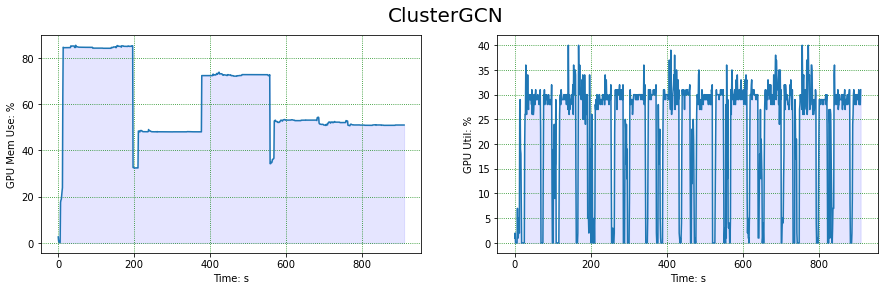

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 4))
plt.subplot(1,2,1)
x = range(0,len(group_gpu_mem_use),1)
plt.plot(x,np.true_divide( np.array(group_gpu_mem_use) - start_gpu_mem_use ,total_gpu_mem)*100)
plt.fill_between(x, np.true_divide(np.array(group_gpu_mem_use) - start_gpu_mem_use ,total_gpu_mem)*100, 0, color='blue', alpha=.1)
plt.xlabel("Time: s")
plt.ylabel("GPU Mem Use: %")
plt.grid(linestyle=":", color="green")
plt.subplot(1,2,2)
x = range(0,len(group_gpu_util),1)
plt.plot(x,np.array(group_gpu_util)-start_gpu_util)
plt.fill_between(x, np.array(group_gpu_util)-start_gpu_util, 0, color='blue', alpha=.1)
plt.xlabel("Time: s")
plt.ylabel("GPU Util: %")
plt.grid(linestyle=":", color="green")
plt.suptitle("ClusterGCN",fontsize=20)
plt.savefig("./figure/BigCluster.png")
plt.show()